<font size=5> Load data

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from collections import Counter

2023-12-02 01:21:47.749311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!find . -name ".DS_Store" -print -delete
# !find . -name ".ipynb_checkpoints" -print -delete

In [3]:
# Assuming image_paths contains paths to your images and label arrays are numpy arrays
# Load images and create a dataset
def process_path(image_path):
    # Read image from file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels as per your images

    # Preprocess or resize the image if needed
    # img = tf.image.resize(img, (512, 512))  # Resize as needed

    # Normalize pixel values to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    return img

def process_image(image_path, label_1, label_2, label_3):
    img = process_path(image_path)  # Process the image using your function

    # Stack labels into one tensor
    labels = tf.stack([label_1, label_2, label_3])

    return img, labels

def visualize_dataset(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (image, labels) in enumerate(dataset.take(num_samples)):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(image.numpy())  # Assuming images are in NumPy format
        plt.title(f"Labels: {labels.numpy()}")  # Assuming labels are in NumPy format
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def preprocess_images_labels(image, label_acl, label_meniscus, label_abnormal):
    processed_image = process_image(image, label_acl, label_meniscus, label_abnormal)  # Assuming process_image directly processes the image
    return processed_image, (label_acl, label_meniscus, label_abnormal)




<font size=5> Load training Data

In [3]:
 #make sure to change accordingly (can use os.chdir("..") to move up a level

# print(os.getcwd())
working_path = '/Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification' #path to workspace
print("workspace path:", working_path)
os.chdir(working_path)
print("current working directory:", os.getcwd())


train_folder_path_images = 'MRNet-v1.0/train_4x4_cropped/rgb_stacks_4x4_cropped'  # Update this with the path to your folder containing .npy files
train_images = sorted(os.listdir(train_folder_path_images))
train_nImages = len(train_images)
print("Num Images train:",train_nImages)
print("train_images[0]:",train_images[0])


#####training labels#####      
temp,train_labels_acl = np.loadtxt("MRNet-v1.0/train-acl.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
temp,train_labels_meniscus = np.loadtxt("MRNet-v1.0/train-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True)
temp,train_labels_abnormal = np.loadtxt("MRNet-v1.0/train-abnormal.csv",
                 delimiter=",", dtype=int, unpack=True)

print("labels1:",train_labels_acl)
print("labels2:",train_labels_meniscus)
print("labels3:",train_labels_abnormal)
# train_labels = list(train_labels) #this is needed for using tf.dataset_from_directory

#ensure the number of labels matches the number of imag
train_labels_acl = train_labels_acl[:train_nImages]
train_labels_meniscus = train_labels_meniscus[:train_nImages]
train_labels_abnormal = train_labels_abnormal[:train_nImages]
print("Num labels train:", len(train_labels_acl))

train_stacked_labels = tf.stack([train_labels_acl, train_labels_meniscus, train_labels_abnormal], axis=-1)

workspace path: /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification
current working directory: /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification
Num Images train: 1130
train_images[0]: rgbAxes_0000.jpeg
labels1: [0 1 0 ... 0 0 1]
labels2: [0 1 0 ... 0 0 0]
labels3: [1 1 1 ... 0 1 1]
Num labels train: 1130


<font size=5> Load validationData

In [4]:
#####validation images#####
valid_folder_path_images = 'MRNet-v1.0/valid_4x4_cropped/rgb_stacks_4x4_cropped'  # Update this with the path to your folder containing .npy files
val_images = sorted(os.listdir(valid_folder_path_images))
# valid_images = sorted([f for f in os.listdir(valid_folder_path_images) if f.lower().endswith('.jpeg')])
valid_nImages = len(val_images)
print("Num Images valid:",valid_nImages)
print("valid_images[0]:",val_images[0])

#validation labels   
temp,val_labels_acl = np.loadtxt("MRNet-v1.0/valid-acl.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
temp,val_labels_meniscus = np.loadtxt("MRNet-v1.0/valid-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True)
temp,val_labels_abnormal = np.loadtxt("MRNet-v1.0/valid-abnormal.csv",
                 delimiter=",", dtype=int, unpack=True)

# print("labels1:",val_labels_acl)
# print("labels2:",val_labels_meniscus)
# print("labels3:",val_labels_abnormal)


# valid_labels = list(valid_labels) #this is needed for using tf.dataset_from_directory

#ensure the number of labels matches the number of images
val_labels_acl = val_labels_acl[:valid_nImages]
val_labels_meniscus = val_labels_meniscus[:valid_nImages]
val_labels_abnormal = val_labels_abnormal[:valid_nImages]
print("Num labels valid:", len(val_labels_acl))

val_stacked_labels = tf.stack([val_labels_acl, val_labels_meniscus, val_labels_abnormal], axis=-1)

Num Images valid: 120
valid_images[0]: rgbAxes_1130.jpeg
Num labels valid: 120


<font size=5> Balance data

In [6]:
# Assuming train_stacked_labels is an array of 3-element vectors
train_stacked_labels_tuples = [tuple(label.numpy()) for label in train_stacked_labels]
labels_counter = Counter(train_stacked_labels_tuples)
print("label counts:", labels_counter)
min_label_count,max_label_count = min(labels_counter.values()),max(labels_counter.values())
print("min_label_count:", min_label_count)

balanced_labels = []
balanced_images = []
for label, image in zip(train_stacked_labels_tuples, train_images):
    # print(image, label)
    bal_labels_counter = Counter(balanced_labels)
    if bal_labels_counter[label] <= min_label_count:

        balanced_labels.append(label)
        balanced_images.append(image)

#save balanced dataset images and labels to folder:
folder_path = 'MRNet-v1.0/train_4x4_cropped'

#Step 2 get current path and create new folder to save data in current path
balanced_images_path = os.path.join(os.getcwd(), folder_path, 'balanced_multi_label_rgb_stacks')

if not os.path.exists(balanced_images_path): 
    os.makedirs(balanced_images_path)
    


# Assuming the files are in the current directory, copy balanced images to new folder
for file_name in balanced_images:
    # Replace 'path_to_your_files_folder' with the path to your original files
    file_path = os.path.join(train_folder_path_images, file_name)
    shutil.copy(file_path, balanced_images_path)    
    
# Name for the CSV file
csv_name = 'balanced_labels_multi_label_train.csv'
if not os.path.exists(csv_name): 
    np.savetxt(csv_name, balanced_labels, delimiter=",", fmt = '%d')
print("Saved csv:", csv_name, "in path", os.getcwd())


# print("\n\n this path will be the path to the balanced images", balanced_images_path)
        

label counts: Counter({(0, 0, 1): 433, (0, 1, 1): 272, (0, 0, 0): 217, (1, 1, 1): 125, (1, 0, 1): 83})


<font size=5> Generate Datasets

In [5]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE



train_image_ds = tf.keras.utils.image_dataset_from_directory(train_folder_path_images, 
                                                       shuffle=False, 
                                                       labels=None, 
                                                       image_size=(512,512),
                                                       batch_size=None)
train_ds = tf.data.Dataset.zip((train_image_ds, tf.data.Dataset.from_tensor_slices(train_stacked_labels)))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)





# train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_stacked_labels))


val_image_ds = tf.keras.utils.image_dataset_from_directory(valid_folder_path_images, 
                                                       shuffle=False, 
                                                       labels=None, 
                                                       image_size=(512,512),
                                                       batch_size=None)
# Create validation dataset similarly
val_ds = tf.data.Dataset.zip((val_image_ds, tf.data.Dataset.from_tensor_slices(val_stacked_labels)))
val_ds = val_ds.shuffle(buffer_size=len(val_images))
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)







#normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 



Found 1130 files belonging to 1 classes.
Found 120 files belonging to 1 classes.


In [9]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))


2023-12-01 13:59:08.302040: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


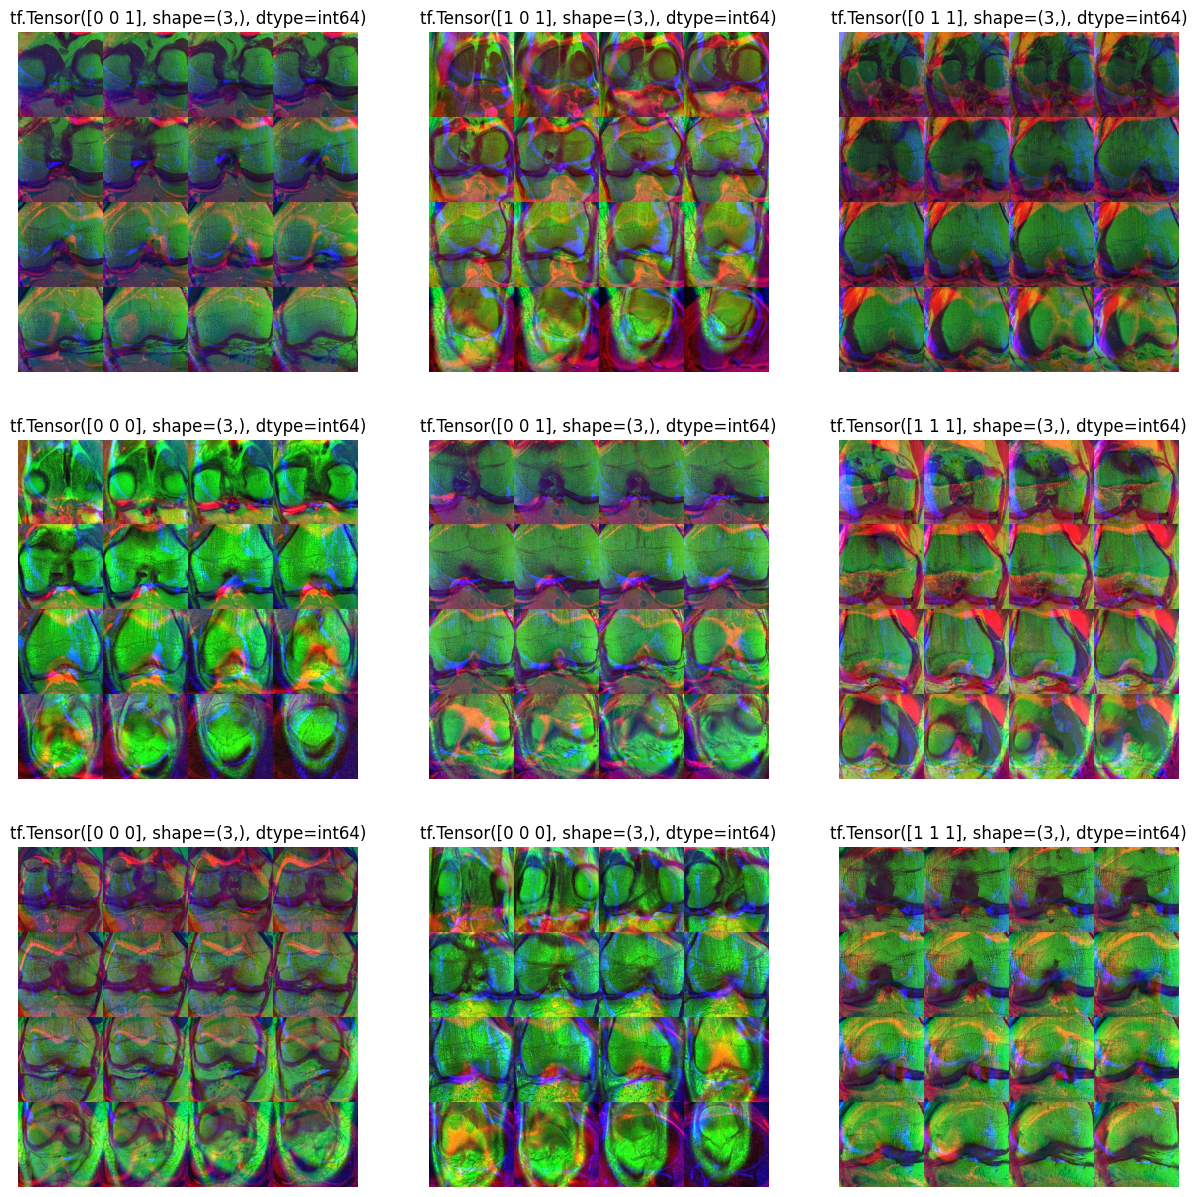

In [10]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(labels[i])
    # plt.xlabel(
    plt.axis("off")


In [11]:
# Assuming train_ds is your dataset containing images and labels
num_samples_to_display = 5

# Get the dimensions of the dataset
num_samples = len(list(train_ds))
image_batch_shape = next(iter(train_ds))[0].shape  # Assuming the shape of the images is consistent
label_batch_shape = next(iter(train_ds))[1].shape

# print(f"Number of samples in the dataset: {num_samples}")
print(f"Shape of each image batch: {image_batch_shape}")
print(f"Shape of each label batch: {label_batch_shape}")


# Display some labels
# print("\nSample labels:")
# for i, (_, labels) in enumerate(train_ds.take(num_samples_to_display), 1):
#     print(f"Sample {i} labels: {labels.numpy()}")

Shape of each image batch: (32, 512, 512, 3)
Shape of each label batch: (32, 3)


<font size=5> Define model

In [30]:
from tensorflow.keras.models import Sequential #functional API exists aswell for fancier stuff
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras
from PIL import ImageFont
from tensorflow.keras.regularizers import l2



# font = PIL.ImageFont.load_default()

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(512, 512, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01)))  # Added another Conv2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output for Dense layers
model.add(Flatten())

# Dense layers
# model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='sigmoid'))# Sigmoid output for multi-label classification 
#https://wandb.ai/ayush-thakur/dl-question-bank/reports/A-Guide-to-Multi-Label-Classification-on-Keras--VmlldzoyMDgyMDU

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience =5,
                               verbose=1,
                               restore_best_weights = True)


visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=1000)

# ######### manual learning rate##########
from tensorflow.keras.optimizers import Adam
custom_learning_rate = 0.00001  # Set your desired learning rate
optimizer = Adam(learning_rate=custom_learning_rate)
model.compile(optimizer=optimizer,
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = tf.keras.losses.BinaryCrossentropy(), #for binary classification
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 256, 256, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 64, 64, 64)       

<font size=5> Separate training data into training and test data

In [7]:
#use some of the training data as test data: 
print("Len of train data before splitting:", int(len(train_ds)))
train_size = int(len(train_ds)*.8) #70% for training
test_size = int(len(train_ds)*.2) #10% for testing might need to add some batches (+...) because int will round down

print("train_size",train_size)
print("test_size", test_size)

# train_ds_final = train_ds.take(train_size)
# test_ds_final = train_ds.skip(train_size-1).take(test_size) #skips everything already used and taking the rest

train_ds_final = train_ds.take(train_size)
test_ds_final = train_ds.skip(train_size)
print("Len of created train_ds_final",len(train_ds_final))
print("Len of created test_ds",len(test_ds_final))

Len of train data before splitting: 36
train_size 28
test_size 7
Len of created train_ds_final 28
Len of created test_ds 8


In [32]:
epochs = 20
history = model.fit(
  train_ds_final,
  validation_data=val_ds,
  callbacks=[early_stopping],
  epochs=epochs
)

Epoch 1/20
28/28 [==============================] - 136s 5s/step - loss: 3.6300 - accuracy: 0.3850 - val_loss: 3.1477 - val_accuracy: 0.1667
Epoch 2/20
28/28 [==============================] - 135s 5s/step - loss: 2.6684 - accuracy: 0.3817 - val_loss: 2.4811 - val_accuracy: 0.1667
Epoch 3/20
28/28 [==============================] - 137s 5s/step - loss: 2.1704 - accuracy: 0.3817 - val_loss: 2.1601 - val_accuracy: 0.1667
Epoch 4/20
28/28 [==============================] - 133s 5s/step - loss: 1.8965 - accuracy: 0.3817 - val_loss: 1.9291 - val_accuracy: 0.1667
Epoch 5/20
28/28 [==============================] - 131s 5s/step - loss: 1.7387 - accuracy: 0.3817 - val_loss: 1.7850 - val_accuracy: 0.1667
Epoch 6/20
28/28 [==============================] - 133s 5s/step - loss: 1.6213 - accuracy: 0.3817 - val_loss: 1.7059 - val_accuracy: 0.1667
Epoch 7/20
28/28 [==============================] - 132s 5s/step - loss: 1.5264 - accuracy: 0.3817 - val_loss: 1.6410 - val_accuracy: 0.1667
Epoch 8/20
28

<font size=5> Plot results of training

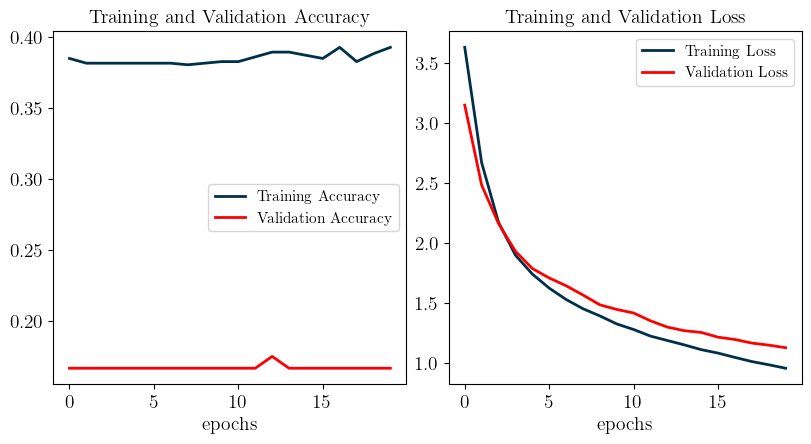

In [33]:
from matplotlib import rc
usetex = True
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8),constrained_layout=True)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 2, color = 'r')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
# plt.axis('scaled')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 2, color = 'r')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
ax.set_box_aspect(1)
# ax.set_aspect('equal', adjustable='box')
# plt.axis('scaled')
# plt.tight_layout()
plt.savefig("TrainingAcc and Loss.png", dpi = 500)
plt.show()

<font size=5> Evaluate on test data

In [143]:
image_batch, labels_batch = next(iter(test_ds_final))

In [170]:
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])

1/1 [==============================] - 4s 4s/step
Precision: 1.000, Recall: 0.395, Accuracy: 0.000, AUC: 0.920
1/1 [==============================] - 0s 205ms/step


TypeError: only length-1 arrays can be converted to Python scalars

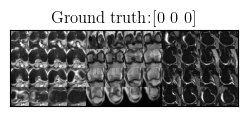

In [165]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC, SparseCategoricalAccuracy, CategoricalAccuracy, Accuracy
from sklearn import metrics
import seaborn as sns
pre = Precision()
re = Recall()
# acc = BinaryAccuracy() for binary model (2 classes)
acc = Accuracy() #for multi class model
AUC = AUC()


test_labels_total = np.array([])
model_predictions_total = np.array([])
for batch in iter(test_ds_final):
    X, y = batch #X are images, y are labels for the batch
    y = np.array(y)
    # test_labels_total = np.append(test_labels_total.astype(int), y.astype(int))
    # print("class",y)
    # print("pred:",yhat)
    yhat = probability_model.predict(X)
    # model_predictions_total = np.concatenate((model_predictions_total.astype(int),yhat.astype(int)))
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    AUC.update_state(y, yhat)
    
    
print("Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}, AUC: {:.3f}"
      .format(pre.result().numpy(), re.result().numpy(), acc.result().numpy(), AUC.result().numpy()))






1/1 [==============================] - 0s 123ms/step


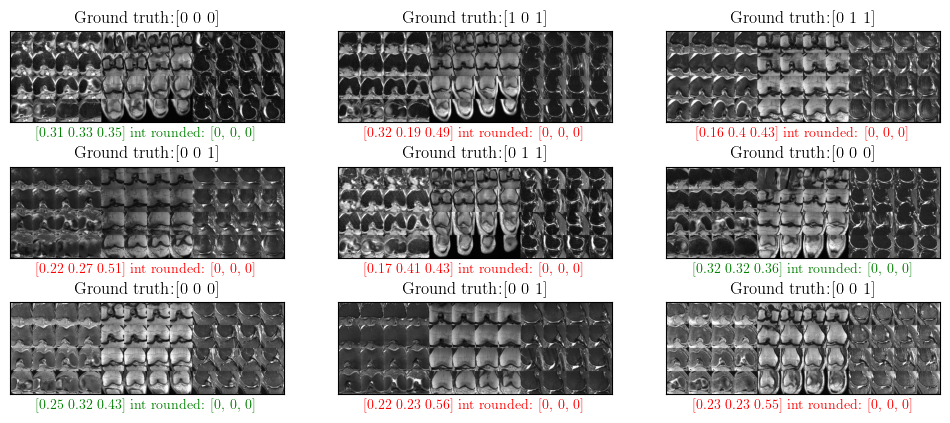

In [182]:
#plot some example images and classifications from a batch
test_image_batch, test_labels_batch = next(iter(test_ds_final))
test_labels_batch = np.array(test_labels_batch)
prediction = probability_model.predict(test_image_batch)
plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_batch[i].numpy())
    img_array = tf.keras.utils.img_to_array(test_image_batch[i])
    img_array = tf.expand_dims(img_array, 0)
    prediction = probability_model.predict(img_array)# Create a batch
    plt.title("Ground truth:" + str(test_labels_batch[i]))
    if (test_labels_batch[i] == [ int(x) for x in prediction[0] ]).all():
        plt.xlabel(str(np.around(prediction[0],2)) + " int rounded: " +str([ int(x) for x in prediction[0] ]), color = 'g')
    else:
        plt.xlabel(str(np.around(prediction[0],2)) + " int rounded: " + str([ int(x) for x in prediction[0] ]), color = 'r')
    


In [130]:
y = tf.constant([1, 2, 3])  # Label tensor 1
z = tf.constant([4, 5, 6])  # Label tensor 2
w = tf.constant([7, 8, 9])  # Label tensor 3

# Stack along the last axis
stacked_labels = tf.stack([val_labels_acl, val_labels_meniscus, val_labels_abnormal], axis=-1)
# print(stacked)